In [2]:
!pwd
import os
os.chdir('../')
!pwd

/Users/Bingumalla Likith/Desktop/MLOPS/Project-2/research
/Users/Bingumalla Likith/Desktop/MLOPS/Project-2


### Modular Programming

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pickle

In [3]:
import pandas as pd 
from dataclasses import dataclass
from pathlib import Path

@dataclass
class DataTransformationConfig:
    root_dir: Path
    data_path: Path

In [4]:
from src.data_science.constants import *
from src.data_science import logger
from src.data_science.utils.common import read_yaml, create_directories

In [5]:
class ConfigurationManager:
    def __init__(self,
                config_path = CONFIG_FILE_PATH,
                params_path = PARAMS_FILE_PATH,
                schema_path = SCHEMA_FILE_PATH):
        self.config = read_yaml(config_path)
        self.params = read_yaml(params_path)
        self.schema = read_yaml(schema_path)
        
        create_directories([self.config.artifacts_root])

    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation
        create_directories([config.root_dir])

        data_validation_config = DataTransformationConfig(**config)
        return data_validation_config

In [268]:
from sklearn.model_selection import train_test_split

In [277]:
class DataTransformation:
    def __init__(self, config:DataTransformationConfig):
        self.config = config
    
    def train_test_splitting(self, data):
        train, test = train_test_split(data, test_size=0.2)
        train.to_csv(os.path.join(self.config.root_dir, 'train.csv'), index=False)
        test.to_csv(os.path.join(self.config.root_dir, 'test.csv'), index=False)

        logger.info("Splitted data into train and test sets")
        logger.info(f"Train data shape -> {train.shape}")
        logger.info(f"Test data shape -> {test.shape}")

        print(train.shape , test.shape)
    
    def transformation(self):
        data = pd.read_csv(self.config.data_path)
        numerical_columns = data.select_dtypes(include='float64').columns.to_list()
        categorical_columns = data.select_dtypes(include='object').columns.to_list()

        numerical_columns.remove('Trip_Price') ## Target variable
        #Based on observation, Passenger count has discrete values that can be encoded as a one-hot-vector
        numerical_columns.remove('Passenger_Count')
        categorical_columns.append('Passenger_Count')

        data.dropna(subset=['Trip_Price'], inplace=True) # Remove rows with null output
        categorical_pipe = Pipeline([
            ('imputer' , SimpleImputer(strategy='most_frequent')),
            ('encoder' , OneHotEncoder(sparse_output=False))
        ])

        numerical_pipe = Pipeline([
            ('imputer' , SimpleImputer(strategy='mean')),
            ('scaler' , StandardScaler())
        ])

        pipeline = ColumnTransformer([
            ('categorical-pipeline' , categorical_pipe , categorical_columns),
            ('numerical-pipeline' , numerical_pipe , numerical_columns)
        ], remainder="passthrough")

        pipeline.fit_transform(data)
        self.train_test_splitting(data)

        with open(os.path.join(self.config.root_dir, 'pipeline.pkl'), 'wb') as file:
            pickle.dump(pipeline, file)

        logger.info(f'Saved the pipeline at {self.config.root_dir} ✅')

In [278]:
try: 
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    data_transformation = DataTransformation(data_transformation_config)

    data_transformation.transformation()
except Exception as e:
    raise e

[2025-01-05 15:55:33,856 : INFO : common : Yaml file : config/config.yaml loaded successfully !!]
[2025-01-05 15:55:33,858 : INFO : common : Yaml file : params.yaml loaded successfully !!]
[2025-01-05 15:55:33,860 : INFO : common : Yaml file : schema.yaml loaded successfully !!]
[2025-01-05 15:55:33,861 : INFO : common : Created directory at : artifacts]
[2025-01-05 15:55:33,862 : INFO : common : Created directory at : artifacts/data_transformation]
[2025-01-05 15:55:33,892 : INFO : 485404275 : Splitted data into train and test sets]
[2025-01-05 15:55:33,892 : INFO : 485404275 : Train data shape -> (760, 11)]
[2025-01-05 15:55:33,893 : INFO : 485404275 : Test data shape -> (191, 11)]
(760, 11) (191, 11)
[2025-01-05 15:55:33,895 : INFO : 485404275 : Saved the pipeline at artifacts/data_transformation ✅]


### Research 

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
path = 'artifacts/data_ingestion/taxi_trip_pricing.csv'
data = pd.read_csv(path)

In [42]:
# Drop data with null output
data.dropna(subset = ['Trip_Price'], inplace=True)

In [43]:
data.info()
numerical_data = data.select_dtypes(include = "float64")
categorical_data = data.select_dtypes(include = "object")

<class 'pandas.core.frame.DataFrame'>
Index: 951 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       901 non-null    float64
 1   Time_of_Day            902 non-null    object 
 2   Day_of_Week            905 non-null    object 
 3   Passenger_Count        903 non-null    float64
 4   Traffic_Conditions     901 non-null    object 
 5   Weather                905 non-null    object 
 6   Base_Fare              907 non-null    float64
 7   Per_Km_Rate            907 non-null    float64
 8   Per_Minute_Rate        902 non-null    float64
 9   Trip_Duration_Minutes  905 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 89.2+ KB


In [7]:
numerical_data.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698
4,NaN,3.0,2.93,0.63,0.32,22.64,15.6180
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028


In [8]:
numerical_data.describe()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,901.000000,903.000000,907.000000,907.000000,902.000000,905.000000,951.000000
mean,27.190998,2.479513,3.497100,1.229934,0.293902,62.044144,56.874773
std,20.155134,1.100983,0.866729,0.429958,0.115404,32.321578,40.469791
min,1.230000,1.000000,2.010000,0.500000,0.100000,5.010000,6.126900
25%,12.630000,2.000000,2.730000,0.850000,0.190000,35.590000,33.742650
50%,25.870000,2.000000,3.510000,1.220000,0.290000,61.570000,50.074500
75%,38.680000,3.000000,4.230000,1.610000,0.390000,89.210000,69.099350
max,146.067047,4.000000,5.000000,2.000000,0.500000,119.840000,332.043689


In [9]:
for col in categorical_data.columns:
    print(col , end=" -> ")
    print(categorical_data[col].unique())

Time_of_Day -> ['Morning' 'Evening' 'Afternoon' 'Night' nan]
Day_of_Week -> ['Weekday' 'Weekend' nan]
Traffic_Conditions -> ['Low' 'High' 'Medium' nan]
Weather -> ['Clear' nan 'Rain' 'Snow']


In [10]:
from src.data_science.utils.common import heat_map, annotate_heatmap

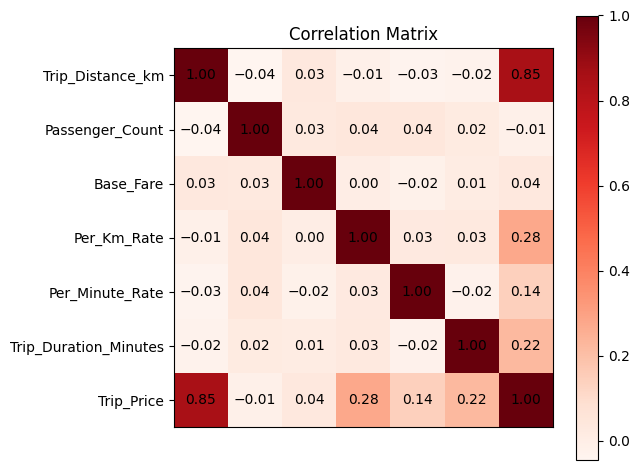

In [44]:
# Analysis of numerical data.
numerical_columns = numerical_data.columns.to_list()

corr = numerical_data.corr().to_numpy()
img, cbar = heat_map(corr, 
                    col_labels=numerical_columns,
                    cmap="Reds")

annotate_heatmap(img, valfmt="{x:.2f}")
plt.tight_layout()
plt.title("Correlation Matrix")
plt.show()

In [12]:
low_correlation_columns = []
threshold = .2
for i, val in enumerate(corr[:, -1]):
    if abs(val) < threshold:
        low_correlation_columns.append(numerical_columns[i])


In [13]:
low_correlation_columns

['Passenger_Count', 'Base_Fare', 'Per_Minute_Rate']

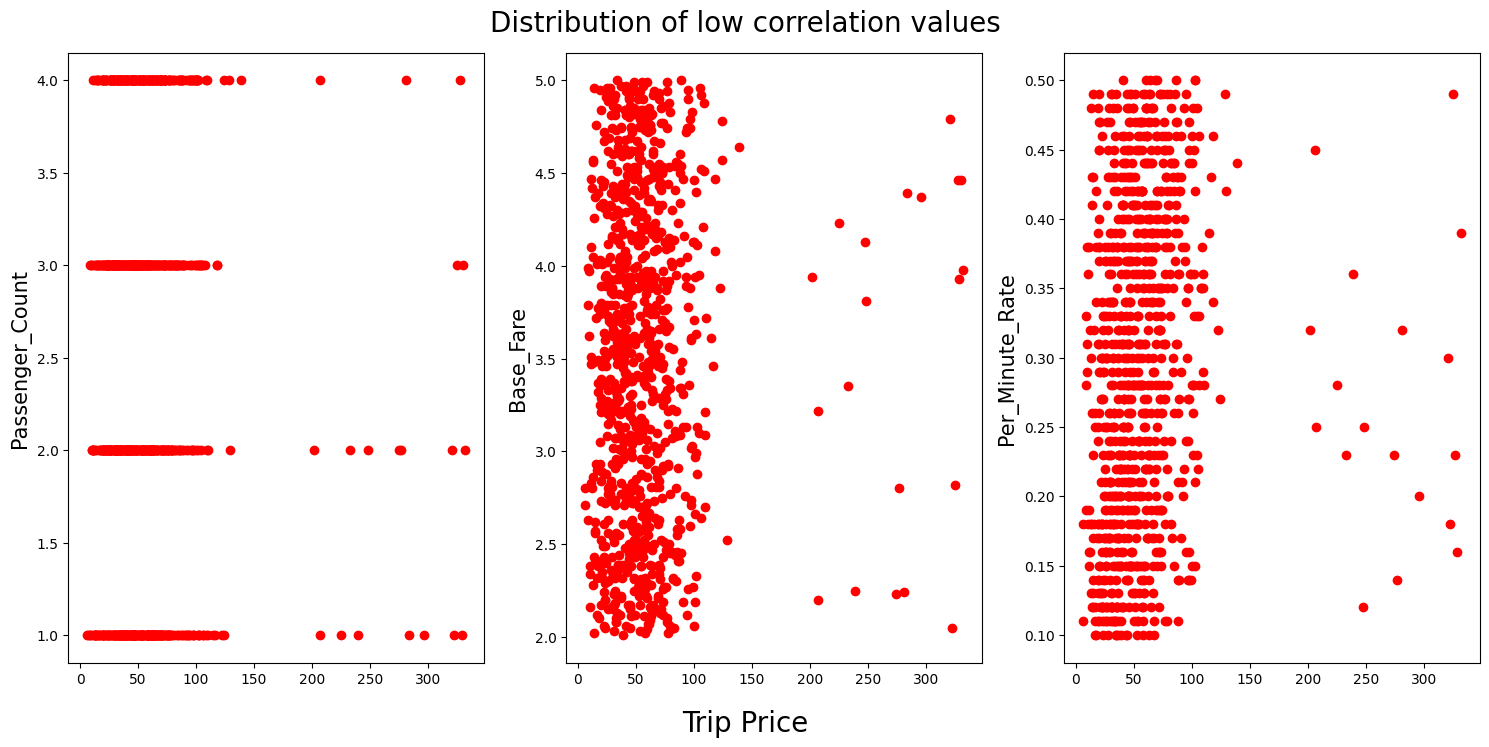

In [14]:
import seaborn as sns

fig , ax = plt.subplots(1, len(low_correlation_columns), figsize=(15, 7.5))
fig.suptitle('Distribution of low correlation values' , fontsize=20)

for i, col in enumerate(low_correlation_columns):
    ax[i].scatter(numerical_data['Trip_Price'], numerical_data[col], color="red")
    ax[i].set_ylabel(col, fontsize=15)

fig.supxlabel('Trip Price', fontsize=20)
plt.tight_layout(rect=[0, 0 , 1 , 1])
plt.show()

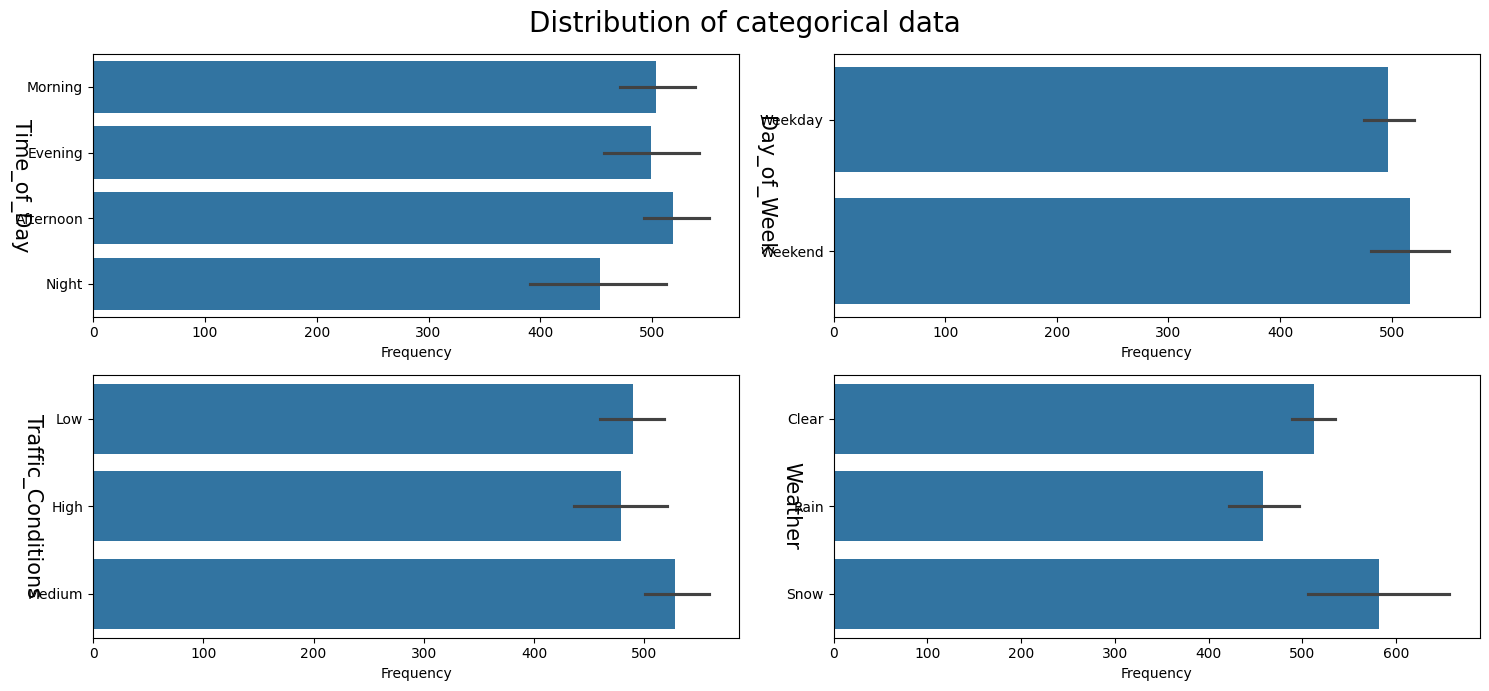

In [45]:
categorical_columns = categorical_data.columns.to_list()

fig, axes = plt.subplots(len(categorical_columns) // 2, 2, figsize=(15, 7))
fig.suptitle('Distribution of categorical data', fontsize=20)
fig.subplots_adjust(wspace=10, hspace=10)
for i, col in enumerate(categorical_columns):
    sns.barplot(categorical_data[col] , ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_xlabel('Frequency')
    axes[i // 2, i % 2].set_ylabel(col, fontsize=15, rotation=-90)

fig.tight_layout()
plt.show()

<p> <strong>Conclusion</strong>: There is a even distribution between all categories and <i>Passenger Count</i> has discrete values that can be converted to one-hot-vector</p>

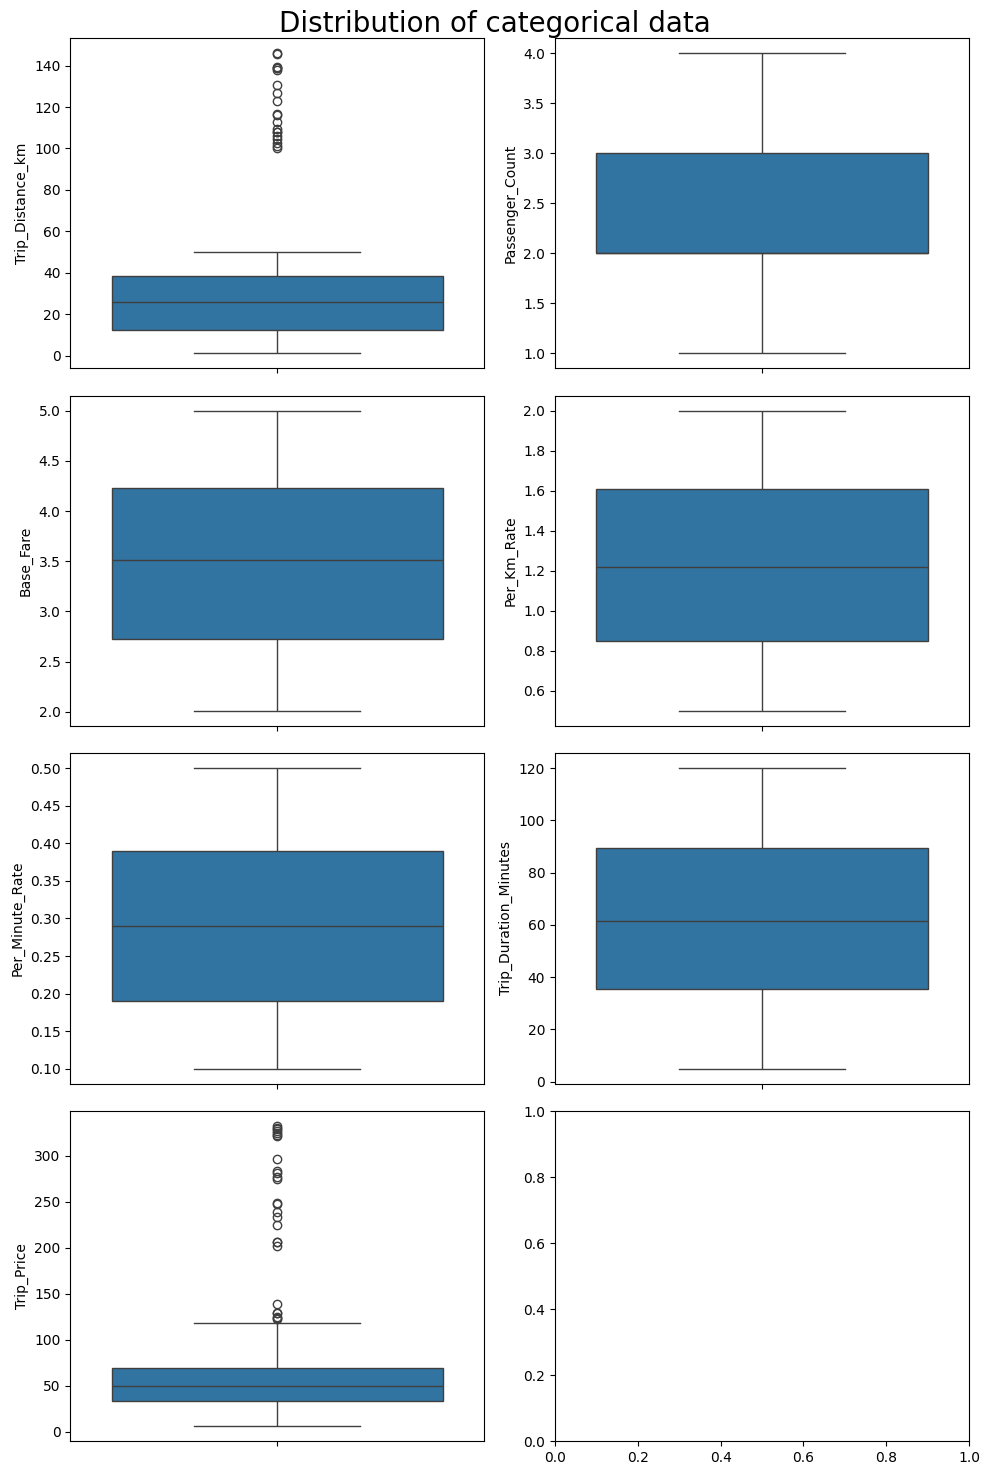

In [16]:
fig, axes = plt.subplots(len(numerical_columns) // 2 + 1, 2, figsize=(10,15))
fig.suptitle('Distribution of categorical data', fontsize=20)
for i, col in enumerate(numerical_columns):
    sns.boxplot(numerical_data[col] , ax=axes[i // 2, i % 2])

fig.tight_layout()
plt.show()

<p><strong>Conclusion : </strong>We can have a small amount of outliers to bring robustness to our model</p>

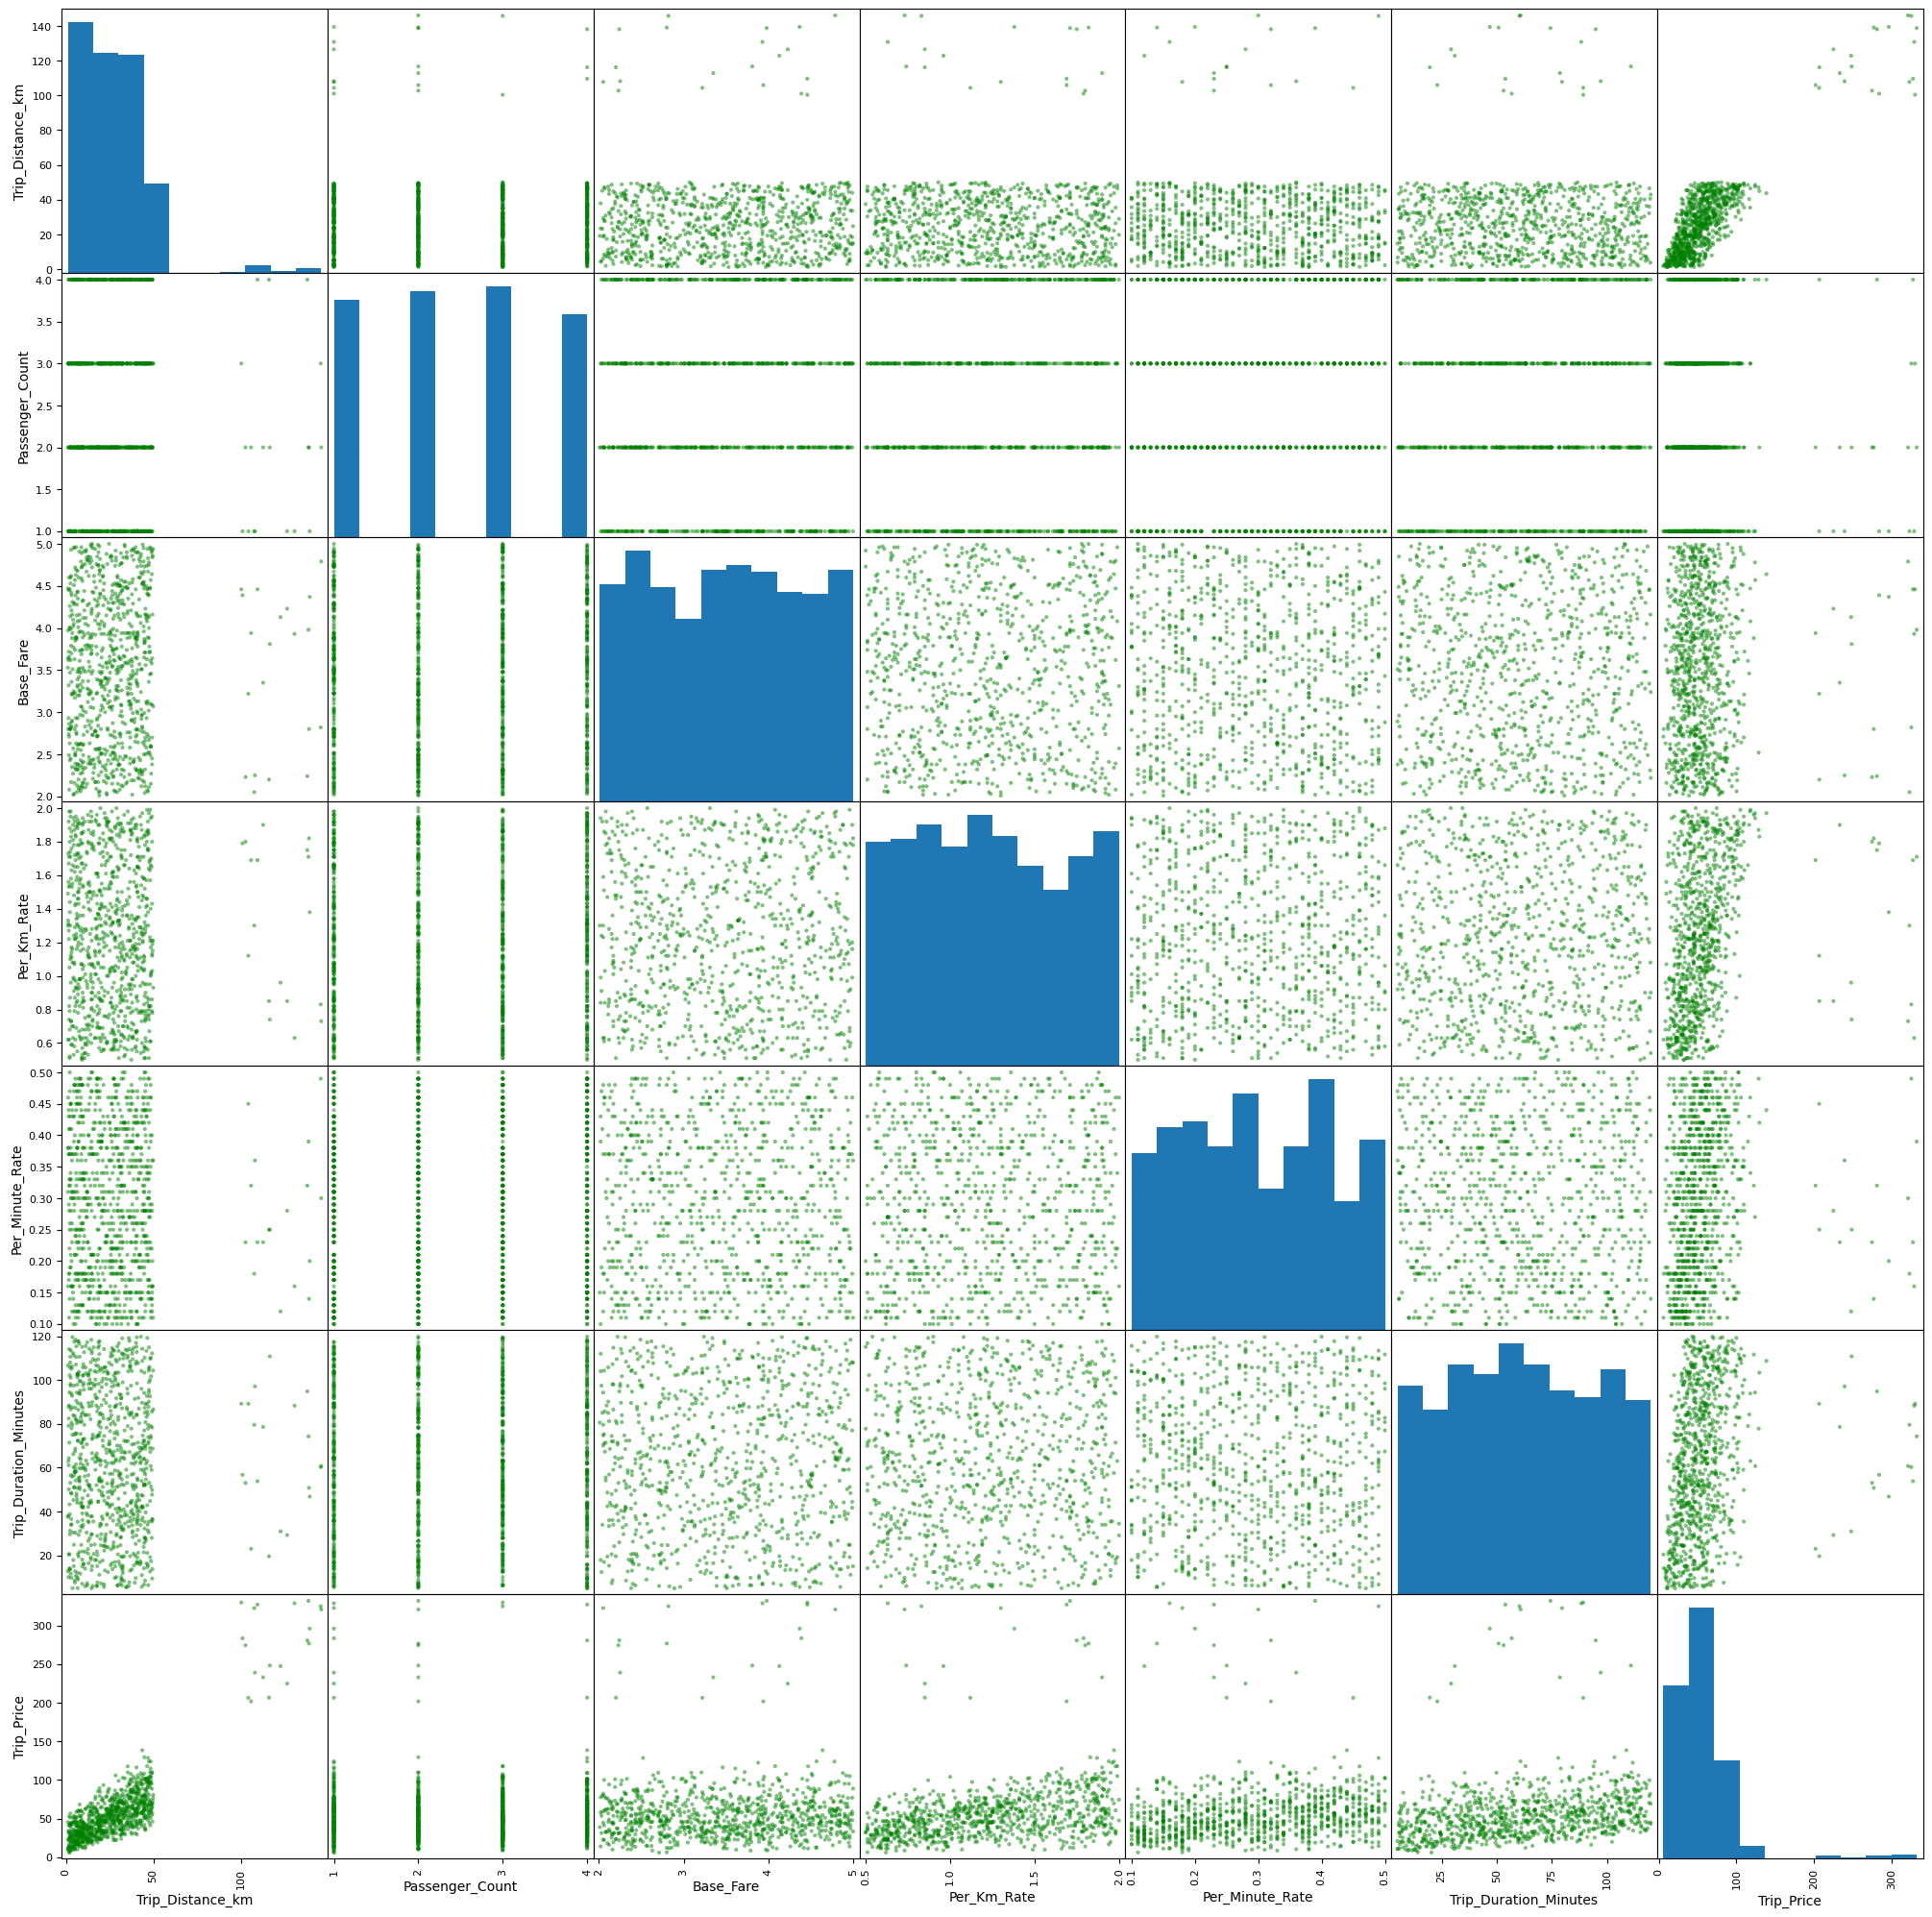

In [17]:
# Let's understand the relationship between different numerical feature
from pandas.plotting import scatter_matrix

axes = scatter_matrix(numerical_data, color="green", figsize=(25, 25))

<p> <strong>Conclusion : </strong>Cannot draw any inference from the distribution</p>